In [1]:
import sys 
sys.path = ['',
 '/cm/shared/sw/pkg-old/devel/python2/2.7.13/bin',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python27.zip',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/plat-linux2',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-tk',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-old',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-dynload',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/IPython/extensions',
 '/mnt/home/llevasseur/.ipython'] 

In [2]:
import tensorflow as tf
import numpy as np

tf.enable_eager_execution()

/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
execfile("AE_RIM_definitions.py")

train_batch_size = 1
num_steps = 10
npix_side = 512
state_size = 128

load_checkpoint_path_1 = "checkpoints/model1_512_N10_logKappa"
load_checkpoint_path_2 = "checkpoints/model2_512_N10_logKappa"
RESTORE_1=True
RESTORE_2=True
save_checkpoint_path_1 = "checkpoints/model1_512_N10_logKappa"
save_checkpoint_path_2 = "checkpoints/model2_512_N10_logKappa"


import matplotlib.pyplot as plt
%matplotlib inline  
from IPython import display
import pylab as pl



In [4]:
src_side = 20.48/2
im_side = 20.48

sk_gen = SRC_KAPPA_Generator(train_batch_size=train_batch_size,test_batch_size=train_batch_size,kap_side_length=im_side, num_src_side=npix_side,num_kappa_side=npix_side,src_side=src_side)
# src_in , kap_in = sk_gen.draw_average_k_s()

RIM = RIM_UNET_CELL(train_batch_size , num_steps , npix_side , state_size)
lens_util_obj = lens_util(im_side= im_side, src_side=src_side, numpix_side = npix_side ,kap_side=im_side,  method = "Unet")

physical_model = lens_util_obj.physical_model
noise_rms = 0.01
sk_gen.draw_k_s("test")

if (RESTORE_1):
    RIM.model_1.load_weights(load_checkpoint_path_1)
if (RESTORE_2):
    RIM.model_2.load_weights(load_checkpoint_path_2)


In [5]:
VAE_obj = VAE(n_latent = 64 , npix_side = npix_side)
checkpoint_path = "checkpoints/model_VAE_512"
VAE_obj.load_weights(checkpoint_path)

In [6]:
VAE_obj_learner = VAE(n_latent = 64 , npix_side = npix_side , output_activation='linear')
learner_checkpoint_path = "checkpoints/model_VAE_512_not_normalized"
VAE_obj_learner.load_weights(learner_checkpoint_path)

In [7]:
FFCNN_obj = FFCNN(load_checkpoint_path = "checkpoints/FFCNN_VAE_weights" , save_checkpoint_path = "checkpoints/FFCNN_VAE_weights" , AUTOENCODER_obj=VAE_obj_learner )
FFCNN_obj.Load()

In [10]:
optimizer = tf.train.AdamOptimizer(1e-8)

In [ ]:
# tr_kap = tf.reshape(VAE_obj.draw_image(train_batch_size), (-1,npix_side,npix_side,1) )

In [ ]:
for train_iter in range(10000000):
    #print train_iter
    sk_gen.draw_k_s("train")
    tr_kap = 3 * tf.reshape(VAE_obj.draw_image(train_batch_size), (-1,npix_side,npix_side,1) ).numpy()
    tr_src = sk_gen.Source_tr[:,:,:,:]
    
    noisy_data = lens_util_obj.simulate_noisy_lensed_image(   tr_src ,tr_kap,noise_rms)
    tf_source =  tf.identity(tr_src)
    tf_kappa  = tf.identity(tr_kap) 
    kappa_first_guess = 10. **(tf.reshape(FFCNN_obj.fullforward_pass(noisy_data) , (-1,npix_side,npix_side,1) ) )
    sourc_first_guess = kappa_first_guess*0.
    #logkappa_first_guess = tf_logkappa
    #logkappa_first_guess = tf_source*0.0 - 4.0

    with tf.GradientTape() as tape:
        tape.watch(RIM.model_1.variables)
        tape.watch(RIM.model_2.variables)
        cost_value, _ , _ , OS_src , OS_kap , dLdPar = RIM.cost_function(noisy_data, tf_source , tf_kappa , sourc_first_guess , kappa_first_guess)
    weight_grads = tape.gradient(cost_value, [RIM.model_1.variables , RIM.model_2.variables] )

    clipped_grads_1 = [tf.clip_by_value(grads_i,-10,10) for grads_i in weight_grads[0]]
    optimizer.apply_gradients(zip(clipped_grads_1, RIM.model_1.variables), global_step=tf.train.get_or_create_global_step())
    clipped_grads_2 = [tf.clip_by_value(grads_i,-10,10) for grads_i in weight_grads[1]]
    optimizer.apply_gradients(zip(clipped_grads_2, RIM.model_2.variables), global_step=tf.train.get_or_create_global_step())
    print train_iter , 1000*(tf.reduce_mean((tf_kappa-kappa_first_guess)**2).numpy() - tf.reduce_mean((tf_kappa-OS_kap)**2).numpy())

    
    
    #print( train_iter , cost_value.numpy() )
    if (((train_iter+1)%2)==0):
        model_im = lens_util_obj.physical_model(OS_src , OS_kap)
        model_im_trsrc = lens_util_obj.physical_model(tr_src , OS_kap)
        model_im_trkap = lens_util_obj.physical_model(OS_src , tf_kappa)
        pl.clf() 
        fig, ax = pl.subplots(4, 4, figsize = (20, 15))
        pl.subplots_adjust(wspace = 0, hspace = 0)
        print tf.reduce_mean((tf_kappa-kappa_first_guess)**2).numpy() , tf.reduce_mean((tf_kappa-OS_kap)**2).numpy()
        imsrcP = ax[0, 0].imshow(OS_src[0,:,:,0])
        immodP = ax[0, 1].imshow(np.log10(OS_kap[0,:,:,0]),vmin=-1.0 , vmax=0.5)
        imsrcT = ax[1, 0].imshow(tf_source[0,:,:,0])
        imsrcT = ax[1, 1].imshow(np.log10(tf_kappa[0,:,:,0]),vmin=-1.0 , vmax=0.5)
        imsrcT = ax[1, 2].imshow(np.log10(kappa_first_guess[0,:,:,0]),vmin=-1.0 , vmax=0.5)


        immodT = ax[2, 0].imshow(noisy_data[0,:,:,0])
        immodP = ax[2, 1].imshow(model_im.numpy()[0,:,:,0])
        immodP = ax[0, 2+0].imshow(tf_kappa[0,:,:,0]-kappa_first_guess.numpy()[0,:,:,0],vmin=-0.5 , vmax=0.5)
        immodP = ax[0, 2+1].imshow(tf_kappa[0,:,:,0]-OS_kap[0,:,:,0],vmin=-0.5 , vmax=0.5)
        immodP = ax[1, 2+1].imshow(noisy_data[0,:,:,0]-model_im.numpy()[0,:,:,0])
        immodP = ax[2, 2+0].imshow(noisy_data[0,:,:,0]-model_im_trkap.numpy()[0,:,:,0])
        immodP = ax[2, 2+1].imshow(noisy_data[0,:,:,0]-model_im_trsrc.numpy()[0,:,:,0])

        
        immodP = ax[3, 0].imshow(dLdPar[0][1][0,:,:,0])
        immodP = ax[3, 1].imshow(dLdPar[1][1][0,:,:,0],vmin=-0.008,vmax=0.008)
        immodP = ax[3, 2].imshow(dLdPar[-2][1][0,:,:,0],vmin=-0.008,vmax=0.008)
        immodP = ax[3, 3].imshow(dLdPar[-1][1][0,:,:,0],vmin=-0.008,vmax=0.008)



        



        for j in range(2):
            for i in range(3):
                ax[i,j].axis('off')    
        display.clear_output(wait=True)
        display.display(pl.gcf())
        print( train_iter , cost_value.numpy() )
#     if (((train_iter+1)%50)==0):
#         RIM.model_1.save_weights(save_checkpoint_path_1)
#         RIM.model_2.save_weights(save_checkpoint_path_2)
#         print('saved weights.')



In [13]:
for train_iter in range(1000000):
    #print train_iter
    sk_gen.draw_k_s("train")
    tr_logkap = tf.log(3 * tf.reshape(VAE_obj.draw_image(train_batch_size), (-1,npix_side,npix_side,1) ).numpy() )
    tr_src = sk_gen.Source_tr[:,:,:,:]
    
    noisy_data = lens_util_obj.simulate_noisy_lensed_image(   tr_src ,tr_logkap,noise_rms)
    tf_source =  tf.identity(tr_src)
    tf_logkappa  = tf.identity(tr_logkap) 
    logkappa_first_guess = np.log(10)* (tf.reshape(FFCNN_obj.fullforward_pass(noisy_data) , (-1,npix_side,npix_side,1) ) )
    sourc_first_guess = logkappa_first_guess*0.
    #logkappa_first_guess = logkappa_first_guess * 0.0001 - 3.0
    #logkappa_first_guess = tf_logkappa
    #logkappa_first_guess = tf_source*0.0 - 4.0

    with tf.GradientTape() as tape:
        tape.watch(RIM.model_1.variables)
        tape.watch(RIM.model_2.variables)
        cost_value, _ , _ , OS_src , OS_kap , dLdPar = RIM.cost_function(noisy_data, tf_source , tf_logkappa , sourc_first_guess , logkappa_first_guess)
    weight_grads = tape.gradient(cost_value, [RIM.model_1.variables , RIM.model_2.variables] )

    clipped_grads_1 = [tf.clip_by_value(grads_i,-10,10) for grads_i in weight_grads[0]]
    optimizer.apply_gradients(zip(clipped_grads_1, RIM.model_1.variables), global_step=tf.train.get_or_create_global_step())
    clipped_grads_2 = [tf.clip_by_value(grads_i,-10,10) for grads_i in weight_grads[1]]
    optimizer.apply_gradients(zip(clipped_grads_2, RIM.model_2.variables), global_step=tf.train.get_or_create_global_step())
    print train_iter , 1000*(tf.reduce_mean((tf_logkappa-logkappa_first_guess)**2).numpy() - tf.reduce_mean((tf_logkappa-OS_kap)**2).numpy())

    
    
    #print( train_iter , cost_value.numpy() )
    if (((train_iter+1)%50)==0):
        model_im = lens_util_obj.physical_model(OS_src , OS_kap)
        model_im_trsrc = lens_util_obj.physical_model(tr_src , OS_kap)
        model_im_trkap = lens_util_obj.physical_model(OS_src , tf_logkappa)
        pl.clf() 
        fig, ax = pl.subplots(4, 4, figsize = (20, 15))
        pl.subplots_adjust(wspace = 0, hspace = 0)
        print tf.reduce_mean((tf_logkappa-logkappa_first_guess)**2).numpy() , tf.reduce_mean((tf_logkappa-OS_kap)**2).numpy()
        imsrcP = ax[0, 0].imshow(OS_src[0,:,:,0])
        immodP = ax[0, 1].imshow((OS_kap[0,:,:,0]),vmin=-2.0 , vmax=1.5)
        imsrcT = ax[1, 0].imshow(tf_source[0,:,:,0])
        imsrcT = ax[1, 1].imshow((tf_logkappa[0,:,:,0]),vmin=-2.0 , vmax=1.5)
        imsrcT = ax[1, 2].imshow((logkappa_first_guess[0,:,:,0]),vmin=-2.0 , vmax=1.5)


        immodT = ax[2, 0].imshow(noisy_data[0,:,:,0])
        immodP = ax[2, 1].imshow(model_im.numpy()[0,:,:,0])
        immodP = ax[0, 2+0].imshow(np.exp(tf_logkappa[0,:,:,0])-np.exp(logkappa_first_guess.numpy()[0,:,:,0]),vmin=-0.5 , vmax=0.5)
        immodP = ax[0, 2+1].imshow(np.exp(tf_logkappa[0,:,:,0])-np.exp(OS_kap[0,:,:,0]),vmin=-0.5 , vmax=0.5)
        immodP = ax[1, 2+1].imshow(noisy_data[0,:,:,0]-model_im.numpy()[0,:,:,0])
        immodP = ax[2, 2+0].imshow(noisy_data[0,:,:,0]-model_im_trkap.numpy()[0,:,:,0])
        immodP = ax[2, 2+1].imshow(noisy_data[0,:,:,0]-model_im_trsrc.numpy()[0,:,:,0])

        
        immodP = ax[3, 0].imshow(dLdPar[0][1][0,:,:,0])
        immodP = ax[3, 1].imshow(dLdPar[-3][1][0,:,:,0],vmin=-0.008,vmax=0.008)
        immodP = ax[3, 2].imshow(dLdPar[-2][1][0,:,:,0],vmin=-0.008,vmax=0.008)
        immodP = ax[3, 3].imshow(dLdPar[-1][1][0,:,:,0],vmin=-0.008,vmax=0.008)



        

        for j in range(2):
            for i in range(3):
                ax[i,j].axis('off')    
        display.clear_output(wait=True)
        display.display(pl.gcf())
        print( train_iter , cost_value.numpy() )
    if (((train_iter+1)%100)==0):
        RIM.model_1.save_weights(save_checkpoint_path_1)
        RIM.model_2.save_weights(save_checkpoint_path_2)
        print('saved weights.')




In [14]:
from scipy.ndimage.interpolation import shift

In [144]:
tr_logkap1 = tf.log(3 * tf.reshape(VAE_obj.draw_image(train_batch_size), (-1,npix_side,npix_side,1) ).numpy() )
tr_logkap2 = tf.log(3 * tf.reshape(VAE_obj.draw_image(train_batch_size), (-1,npix_side,npix_side,1) ).numpy() )

In [145]:
kap1 = shift(np.exp(tr_logkap1[0,:,:,0]), (0,0), output=None, order=3, mode='constant', cval=0.0001, prefilter=True)
kap2 = shift(np.exp(tr_logkap2[0,:,:,0]), (0,0), output=None, order=3, mode='constant', cval=0.0001, prefilter=True)

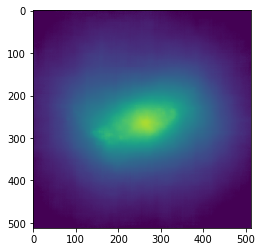

In [146]:
tot_kap = 1.*kap1+0.0*kap2
tr_logkap = tf.log(tf.reshape(tot_kap,(1,512,512,1)))

pl.imshow(tr_logkap[0,:,:,0],vmin=-2.0 , vmax=1.5)

0.016403304 0.005208823


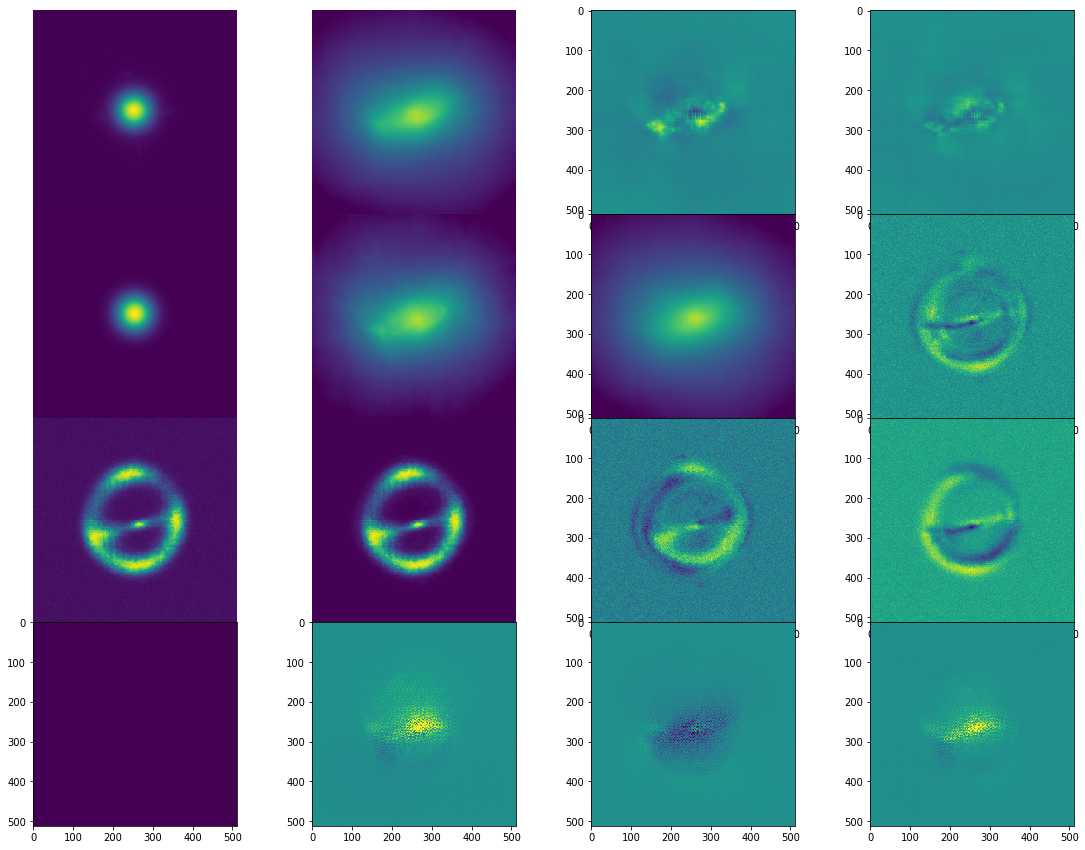

In [147]:
sk_gen.draw_k_s("train")


tr_src = sk_gen.Source_tr[:,:,:,:]

outim = shift(OS_kap[0,:,:,0], (60,60), output=None, order=3, mode='constant', cval=0.0, prefilter=True)

noisy_data = lens_util_obj.simulate_noisy_lensed_image(   tr_src ,tr_logkap,noise_rms)
tf_source =  tf.identity(tr_src)
tf_logkappa  = tf.identity(tr_logkap) 
logkappa_first_guess = np.log(10)* (tf.reshape(FFCNN_obj.fullforward_pass(noisy_data) , (-1,npix_side,npix_side,1) ) )
sourc_first_guess = logkappa_first_guess*0.

cost_value, _ , _ , OS_src , OS_kap , dLdPar = RIM.cost_function(noisy_data, tf_source , tf_logkappa , sourc_first_guess , logkappa_first_guess)


model_im = lens_util_obj.physical_model(OS_src , OS_kap)
model_im_trsrc = lens_util_obj.physical_model(tr_src , OS_kap)
model_im_trkap = lens_util_obj.physical_model(OS_src , tf_logkappa)
pl.clf() 
fig, ax = pl.subplots(4, 4, figsize = (20, 15))
pl.subplots_adjust(wspace = 0, hspace = 0)
print tf.reduce_mean((tf_logkappa-logkappa_first_guess)**2).numpy() , tf.reduce_mean((tf_logkappa-OS_kap)**2).numpy()
imsrcP = ax[0, 0].imshow(OS_src[0,:,:,0])
immodP = ax[0, 1].imshow((OS_kap[0,:,:,0]),vmin=-2.0 , vmax=1.5)
imsrcT = ax[1, 0].imshow(tf_source[0,:,:,0])
imsrcT = ax[1, 1].imshow((tf_logkappa[0,:,:,0]),vmin=-2.0 , vmax=1.5)
imsrcT = ax[1, 2].imshow((logkappa_first_guess[0,:,:,0]),vmin=-2.0 , vmax=1.5)


immodT = ax[2, 0].imshow(noisy_data[0,:,:,0])
immodP = ax[2, 1].imshow(model_im.numpy()[0,:,:,0])
immodP = ax[0, 2+0].imshow(np.exp(tf_logkappa[0,:,:,0])-np.exp(logkappa_first_guess.numpy()[0,:,:,0]),vmin=-0.5 , vmax=0.5)
immodP = ax[0, 2+1].imshow(np.exp(tf_logkappa[0,:,:,0])-np.exp(OS_kap[0,:,:,0]),vmin=-0.5 , vmax=0.5)
immodP = ax[1, 2+1].imshow(noisy_data[0,:,:,0]-model_im.numpy()[0,:,:,0])
immodP = ax[2, 2+0].imshow(noisy_data[0,:,:,0]-model_im_trkap.numpy()[0,:,:,0])
immodP = ax[2, 2+1].imshow(noisy_data[0,:,:,0]-model_im_trsrc.numpy()[0,:,:,0])


immodP = ax[3, 0].imshow(dLdPar[0][1][0,:,:,0])
immodP = ax[3, 1].imshow(dLdPar[-3][1][0,:,:,0],vmin=-0.008,vmax=0.008)
immodP = ax[3, 2].imshow(dLdPar[-2][1][0,:,:,0],vmin=-0.008,vmax=0.008)
immodP = ax[3, 3].imshow(dLdPar[-1][1][0,:,:,0],vmin=-0.008,vmax=0.008)





for j in range(2):
    for i in range(3):
        ax[i,j].axis('off')    


In [148]:
tr_logkap = tf.log(tf.reshape(VAE_obj.draw_image(32), (-1,npix_side,npix_side,1) ).numpy() )